In [5]:
!pip install imblearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn packages (for pre-processing, model-building, evaluators, cross-validators, etc.)
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, roc_auc_score, f1_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder

# Imblearn packages (for over_sampling and imblearn pipelines)
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline  ## Using packages from imblearn.pipeline for making pipelines

## xgboost packages
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

In [6]:
df_cct = pd.read_parquet("/home/onyxia/work/df_cct_stand2.parquet")

### Correlation map

<Axes: >

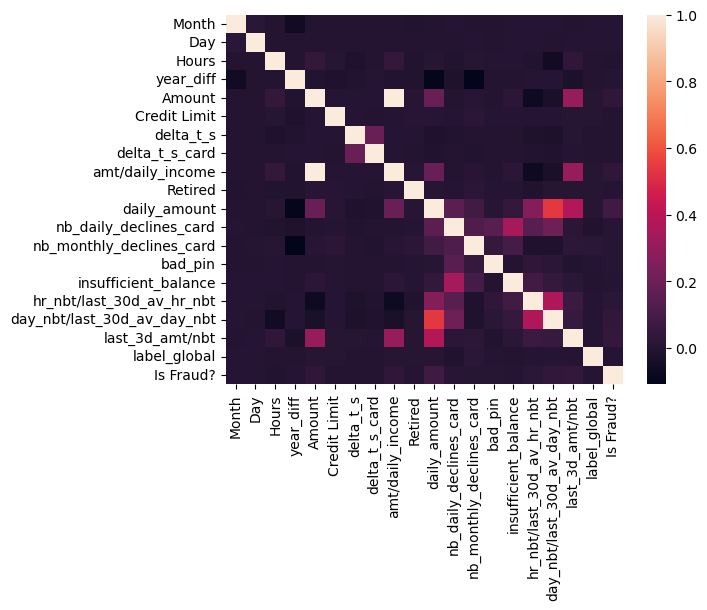

In [3]:
sns.heatmap(df_cct[['Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'label_global',
       'Is Fraud?']].corr())

In [4]:
df_cct.columns

Index(['User', 'Card', 'Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Use Chip', 'Card Brand', 'Card Type', 'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'label_global',
       'Is Fraud?'],
      dtype='object')

### Preprocessing (code to create standarized (by User) dataset) - DO NOT RUN

In [19]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num = df_cct.loc[:,~df_cct.columns.isin(["User","Card","label_global","Retired", "bad_pin", "insufficient_balance","Is Fraud?"])].select_dtypes(include=numerics).columns.to_list()
cat = df_cct.select_dtypes(include=['object']).columns.to_list()


In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df = pd.DataFrame()
for i in range(2000):
    user_i = df_cct[df_cct["User"] == i]
    user_i[num] = scaler.fit_transform(user_i[num])
    df = pd.concat([df,user_i], axis=0)


In [51]:
#df.to_parquet("/home/onyxia/work/df_cct_stand2.parquet")

### Encode categorical variables

In [7]:
# Pour "Use Chip":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Use Chip"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [8]:
# Pour "Card Brand":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Card Brand"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [9]:
# Pour "Card Type"":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Card Type"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [6]:
df_cct.columns

Index(['User', 'Card', 'Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Use Chip', 'Card Brand', 'Card Type', 'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'label_global',
       'Is Fraud?', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction', 'Amex', 'Discover', 'Mastercard', 'Visa', 'Credit',
       'Debit', 'Debit (Prepaid)'],
      dtype='object')

### Create train/val/test datasets

In [10]:
# selecting features
# dropped card, nb_weekly_declines, day_of_week, nb_daily_declines, credit, debit, amex,  discover,
# mastercard, visa
features = ['Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction','Debit (Prepaid)',
        "label_global","Is Fraud?"]
df_selec = df_cct[features] # 21 features
X = df_selec[['Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction','Debit (Prepaid)']]
y = df_selec["Is Fraud?"]

In [60]:
## Splitting the data into train and test data  (70:30)

## Create a STRATIFIED train-test (Hence, passing the argument 'stratify= y')
# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.7, shuffle = True, random_state = 0, stratify = y)


In [61]:
## Checking class distribution in stratified train-test split
from collections import Counter

print("In y dataset:", Counter(y))
print("\nIn y_train set:", Counter(y_train))
print("\nIn y_test set:", Counter(y_rem))

In y dataset: Counter({0: 24357143, 1: 29757})

In y_train set: Counter({0: 17050000, 1: 20830})

In y_test set: Counter({0: 7307143, 1: 8927})


In [63]:
df_rem = df_selec.loc[X_rem.index]

In [68]:
# Now since we want the valid and test size to be equal (15% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)

df_val = df_rem.sample(int(len(X_rem)*0.5), random_state = 0)
X_val = df_val.drop(["label_global", "Is Fraud?"], axis = 1)
y_val = df_val["Is Fraud?"]
df_test = df_rem.loc[~df_rem.index.isin(df_val.index.tolist())]
X_test = df_test.drop(["label_global", "Is Fraud?"], axis = 1)
y_test = df_test["Is Fraud?"]


In [84]:
# almost stratified

print("In y dataset:", Counter(y_rem))
print("\nIn y_val set:", Counter(y_val))
print("\nIn y_test set:", Counter(y_test))

In y dataset: Counter({0: 7307143, 1: 8927})

In y_val set: Counter({0: 3653663, 1: 4372})

In y_test set: Counter({0: 3653480, 1: 4555})


In [78]:
# Storing indexes for our score

i_val = df_val.index.to_list()
i_test = df_test.index.to_list()

### Model Building

In [80]:
#Create a pandas dataframe to store model results
results_df = pd.DataFrame(columns=['Data Handling Technique','Model', 'ROC_AUC_cv', 'ROC_AUC_test', 'Threshold', 'Precision','Recall','F1 score', "Our Score"])

In [81]:
## Define a function to plot ROC_AUC curve
def plot_roc_auc_curve(fpr, tpr, roc_auc):
    print(f"ROC for test dataset {round(roc_auc*100,3)}%")  
    plt.figure(figsize=(5,5))
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.plot(fpr,tpr,'b',label="Test ROC_AUC="+str(round(roc_auc,3)))
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.legend(loc='lower right')
    plt.show()

## Function for printing the cross-validation results:
def best_cross_val_results(clf,data_handling_technique, model_name):
    print("\nData Handling Technique: {data_handling_technique}\nModel Name: {model_name}")
    print("\n\nEvaluation results from cross-validation and optimal hyperparameters")
    # Best Model and optimal hyperparameters
    print("Best Estimator:\n", clf.best_estimator_._final_estimator)
    print("Best ROC_AUC (mean cross-validated score):", clf.best_score_)
    print("Best (Optimal) Parameters:", clf.best_params_)

# Function for prediction and evaluation results on test data:
def prediction_evaluation_results(clf,X_train,y_train,X_test,y_test, data_handling_technique,model_name,results_df):
    print("\nPrediction and Evaluation results: On Actual TEST SET")
    y_pred= clf.predict(X_test)                                             # Find predicted values
    y_pred_probs = clf.predict_proba(X_test)[:,1]                           # Find predicted probabilities
    precision = metrics.precision_score(y_pred=y_pred, y_true=y_test)           # Precision and Recall Scores
    recall= metrics.recall_score(y_pred=y_pred, y_true=y_test)
    f1_score= metrics.f1_score(y_pred=y_pred, y_true=y_test)                    # f1_score
    test_roc_auc = metrics.roc_auc_score(y_score= y_pred_probs, y_true=y_test)  # Test ROC_AUC
    print(f"\nTest ROC_AUC: {test_roc_auc}")
    test_accuracy = metrics.accuracy_score(y_pred=y_pred, y_true=y_test)        # test accuracy
    print(f"Test Accuracy: {test_accuracy}");print()
    print("Confusion Matrix")                                                   # print confusion matrix
    print_model_metrics(y_test, y_pred)
    print("Classification Report")                                              # Print classification report
    print(classification_report(y_test, y_pred))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs)              # fpr, tpr and threshold
    threshold= thresholds[np.argmax(tpr-fpr)]                                   # Find the optimal threshold value
    print("Optimal Threshold:", threshold)
    plot_roc_auc_curve(fpr, tpr, test_roc_auc)                                  # Plot ROC_AUC curve for test dataset (using defined function)
    ## Store results 
    results_store_df= pd.DataFrame({'Data Handling Technique': [data_handling_technique],'Model': [model_name],
                            'ROC_AUC_cv': [clf.best_score_],'ROC_AUC_test': [test_roc_auc],'Threshold': [threshold],
                                    'Precision': [precision],'Recall': [recall],'F1 score':[f1_score]})
    return results_store_df

In [85]:
## Defining a function for building a  DecisionTree_StratifiedKFoldCV_Model() - to cross-validate, tune hyperparameters,  
##  build optimal model and provide evaluation results.
import datetime
import time
def DecisionTree_StratifiedKFoldCV_Model(sampling_technique,X_train, y_train, X_test, y_test, data_handling_technique, model_name, results_df):
    start= time.time()
    print("*"*100)
    
    np.random.seed(0)
    ## StratifiedKFold cross-validator
    cv_num=3
    skf = StratifiedKFold(n_splits= cv_num, random_state=0, shuffle=True)       ## Note: number of cross-validation splits, cv_num=3 (defined previously)   
    ## Perform cross-validation and hyperparameter tuning 

    # Create a pipeline: (Advatange: Flow of code and pipelines also make sure that validation sets are not oversampled within folds)
    if sampling_technique==None:
        pipe_dt= make_pipeline(DecisionTreeClassifier(random_state=0))                          # Defining the model 
    else:
        pipe_dt= make_pipeline(sampling_technique, DecisionTreeClassifier(random_state=0))
        
    max_depth=list(range(1,21,2))                                        ## Hyperparameter: max_depth to be tuned
    min_samples_leaf = [1,5,10,20,30,50,100]                                   ## Hyperparameter: min_samples_leaf to be tuned
    criterion= ['gini','entropy']                                        ## Hyperparameter: criterion to be tuned
    max_features=['sqrt','log2',None]                                    ## Hyperparameter: max_features to be tuned
    # Params_distributions
    params_dt={ 
                'decisiontreeclassifier__min_samples_leaf':min_samples_leaf,
                'decisiontreeclassifier__max_features':max_features,
                'decisiontreeclassifier__max_depth':max_depth,
                'decisiontreeclassifier__criterion':criterion}
  
    clf= RandomizedSearchCV(                                                    # Performing cross-validation
                            estimator=pipe_dt, 
                            param_distributions=params_dt,
                            n_jobs=-1,
                            pre_dispatch = 2, 
                            cv=skf,
                            scoring='f1',                                  ## Scoring metric 'f1'
                            verbose = 1,
                            n_iter=40,
                            return_train_score=True,
                            error_score=0)
    clf.fit(X_train, y_train)   
    optimal_min_samples_leaf=int(clf.best_params_['decisiontreeclassifier__min_samples_leaf'])
    optimal_max_features= clf.best_params_['decisiontreeclassifier__max_features']  
    optimal_max_depth= int(clf.best_params_['decisiontreeclassifier__max_depth'])    
    optimal_criterion= clf.best_params_['decisiontreeclassifier__criterion']      
    best_cross_val_results(clf,data_handling_technique, model_name)          # Get best cross_validation results
    # Initialize the model with optimal hyperparameters
    clf_opt= clf.best_estimator_._final_estimator     ## Best estimator already found out above, after fitting on (X_train,y_train)

    print("\nOptimal hyperparameters:")
    print("Best min_samples_leaf:", optimal_min_samples_leaf)
    print("Best max_features:", optimal_max_features)
    print("Best max_depth:", optimal_max_depth)
    print("Best criterion:", optimal_criterion)
    # prediction and evaluation results on actual TEST data
    results_store_df= prediction_evaluation_results(clf, X_train, y_train, X_test, y_test, 
                                                    data_handling_technique, model_name, results_df)
    results_df= results_df.append(results_store_df, ignore_index=True)  ## Appending the results to 'results_df' dataframe
    end= time.time()
    time_req_mins = (end-start)/60
    print(f"\nTime required to train the model: {round(time_req_mins)} minutes")
    print("*"*100)
    return results_df, clf_opt 

****************************************************************************************************
Fitting 3 folds for each of 40 candidates, totalling 120 fits

Data Handling Technique: {data_handling_technique}
Model Name: {model_name}


Evaluation results from cross-validation and optimal hyperparameters
Best Estimator:
 DecisionTreeClassifier(criterion='entropy', max_depth=19, random_state=0)
Best ROC_AUC (mean cross-validated score): 0.1556722978543519
Best (Optimal) Parameters: {'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__max_depth': 19, 'decisiontreeclassifier__criterion': 'entropy'}

Optimal hyperparameters:
Best min_samples_leaf: 1
Best max_features: None
Best max_depth: 19
Best criterion: entropy

Prediction and Evaluation results: On Actual TEST SET

Test ROC_AUC: 0.6045158894756064
Test Accuracy: 0.9984212835579758

Confusion Matrix
 Model Stats Scores Summary : 


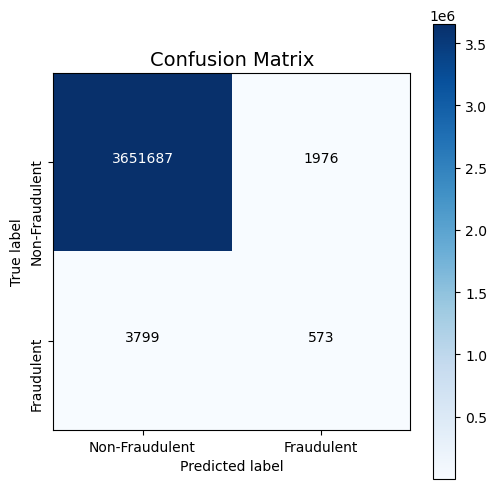

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   3653663
           1       0.22      0.13      0.17      4372

    accuracy                           1.00   3658035
   macro avg       0.61      0.57      0.58   3658035
weighted avg       1.00      1.00      1.00   3658035

Optimal Threshold: 0.0014492753623188406
ROC for test dataset 60.452%


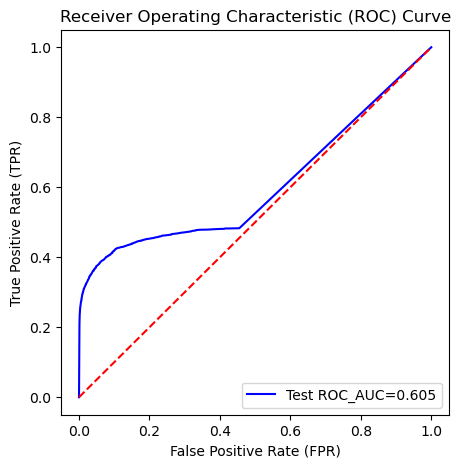

AttributeError: 'DataFrame' object has no attribute 'append'

In [88]:
## Decision Tree Model [Imbalanced Dataset]
results_df, clf_dt_imbal_data = DecisionTree_StratifiedKFoldCV_Model(None, X_train, y_train, X_val, y_val, 
                         "Imbalanced Dataset", "Decision Tree with StratifiedKFoldCV", results_df)

In [87]:
def plot_confusion_matrix(cm):
    """
    This function prints and plots the confusion matrix.
    """
    classes=['Non-Fraudulent','Fraudulent']
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix', fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes, rotation=90)
    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontsize= 10)
    plt.xlabel('Predicted label', fontsize=10)


def print_model_metrics(y_test,y_pred):
    print(" Model Stats Scores Summary : ")
    cp = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(cp)
    plt.show()

### Base - first model

In [14]:
# Build and train model without any hyperparameters
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)
print(decision_tree.tree_.max_depth)
# Apply model to validation data
y_pred_dt_base = decision_tree.predict(X_val)


46


Classification metrics: 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     50000
           1       0.92      0.16      0.28      5000

    accuracy                           0.92     55000
   macro avg       0.92      0.58      0.62     55000
weighted avg       0.92      0.92      0.90     55000



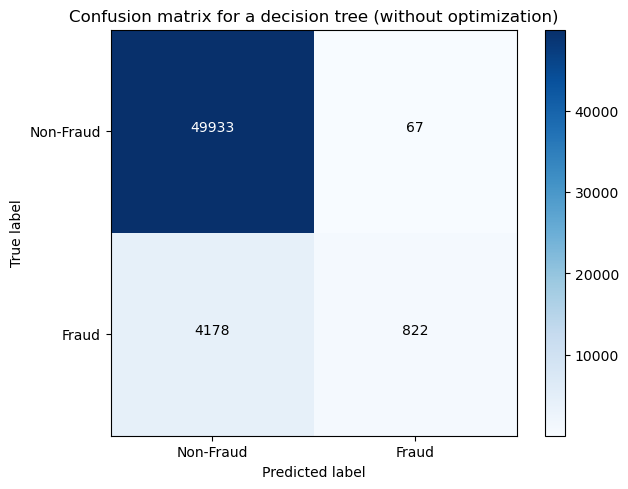

In [15]:
# Evaluate model
print('Classification metrics: \n', classification_report(y_val, y_pred_dt_base))
# plot confusion matrix function
import itertools

def plot_confusion_matrix(cm,normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        classes=['Non-Fraud','Fraud']
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=0)
        plt.yticks(tick_marks, classes)
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            # print("Normalized confusion matrix")
        else:
            1  # print('Confusion matrix, without normalization')

        # print(cm)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        return ()


cnf_matrix_dtree = confusion_matrix(y_val, y_pred_dt_base)
plt.figure()
plot_confusion_matrix(cnf_matrix_dtree, title='Confusion matrix for a decision tree (without optimization)')
plt.show()

In [16]:
# defining our own cost score
def our_score(y_test, y_pred) :
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    cost = 45*tp - 40*fn - 15*fp
    return cost

In [17]:
our_score(y_val, y_pred_dt_base)

-131135

### SHAP values

In [25]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(decision_tree)

In [16]:
# selecting 15,000 frauds and 15,000 non frauds from train set
# otherwise, computation time is too big

X_train_shap = pd.concat([X_train_fraud, X_train_no_fraud.sample(len(X_train_fraud), random_state = 42)], axis = 0)

In [26]:
shap_values = explainer.shap_values(X_train_shap)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


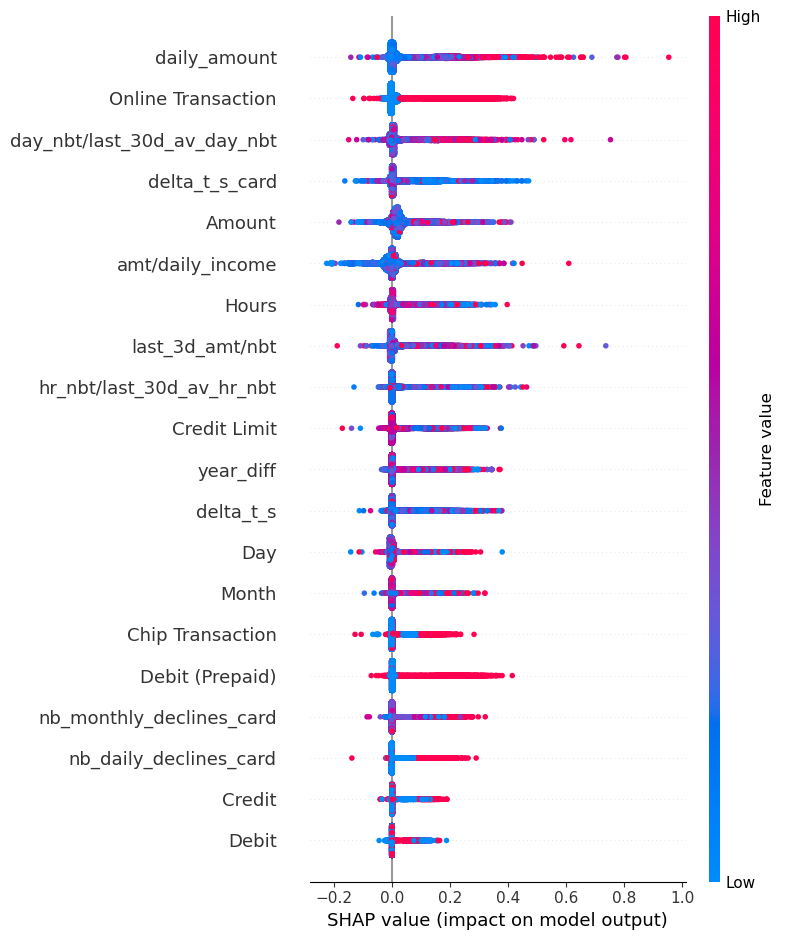

In [29]:
shap.summary_plot(shap_values[1], X_train_shap)

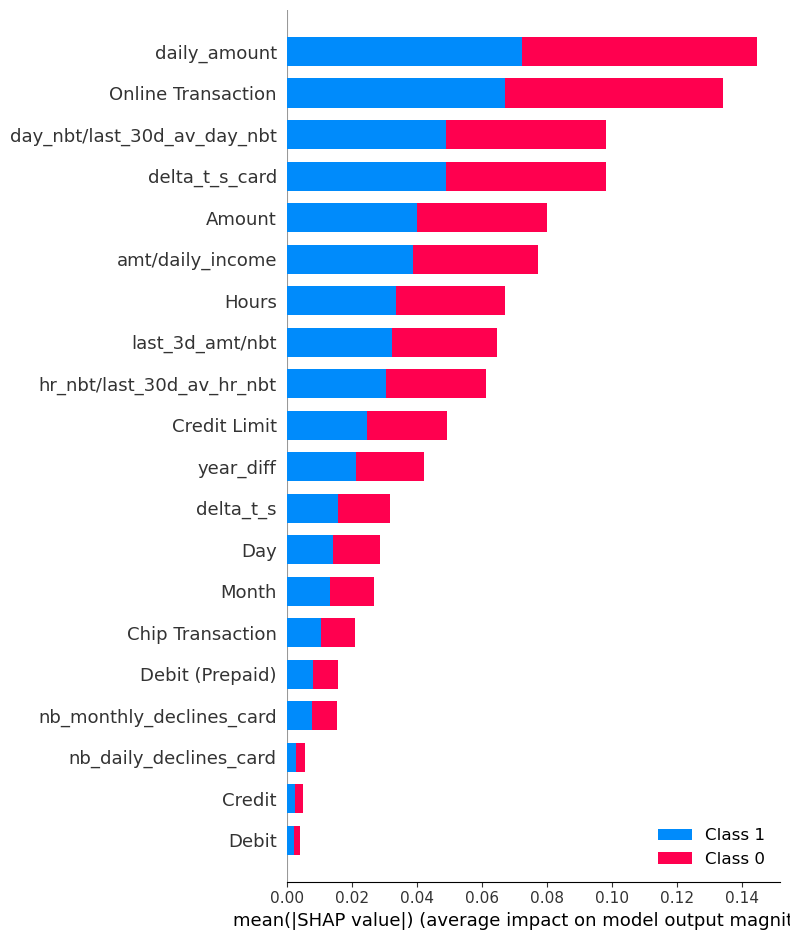

In [27]:
shap.summary_plot(shap_values, X_train_shap ,feature_names = X_train_shap.columns, plot_type="bar") 
# we can drop the 7 last ones : mastercard, amex, visa, discover, debit, credit, nb_daily_declines_card

### Tuning Hyperparameters

In [12]:
df_f1_score1 = pd.DataFrame(columns = ["class_weight_1", "f1score"])
for i in range(90, 100):
    dt = DecisionTreeClassifier(class_weight = {1:i/100,0:1-i/100}, random_state=42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    score = f1_score(y_pred, y_test)
    df_f1_score1.loc[len(df_f1_score1)] = [i/100, score]
df_f1_score1

,class_weight_1,f1score
0,0.90,0.285134
1,0.91,0.288949
2,0.92,0.282605
3,0.93,0.272276
4,0.94,0.256357
5,0.95,0.261198
6,0.96,0.258674
7,0.97,0.254433
8,0.98,0.236402
9,0.99,0.246922


Text(0.5, 1.0, 'f1-score according to class_weight (decision tree)')

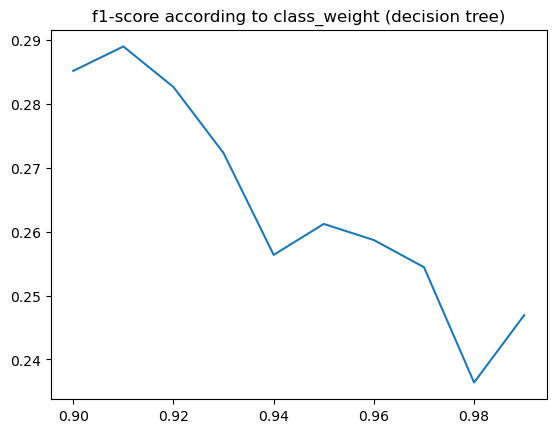

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(df_f1_score1.iloc[:,0].values, df_f1_score1.iloc[:,1].values)
plt.title('f1-score according to class_weight (decision tree)')

In [14]:
df_f1_score = pd.DataFrame(columns = ["min_samples_leaf", "f1score"])
for i in range(1, 100, 5):
    dt = DecisionTreeClassifier(class_weight = {1:df_f1_score1.iloc[df_f1_score1["f1score"].idxmax(), 0],0:1 - df_f1_score1.iloc[df_f1_score1["f1score"].idxmax(), 0]}, min_samples_leaf=i, random_state=42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    score = f1_score(y_pred, y_test)
    df_f1_score.loc[len(df_f1_score)] = [i, score]
df_f1_score    

,min_samples_leaf,f1score
0,1.0,0.288949
1,6.0,0.391284
2,11.0,0.422653
3,16.0,0.426115
4,21.0,0.440943
5,26.0,0.436834
6,31.0,0.446154
7,36.0,0.445321
8,41.0,0.447874
9,46.0,0.448683


Text(0.5, 1.0, 'f1-score according to min_samples_leaf (decision tree)')

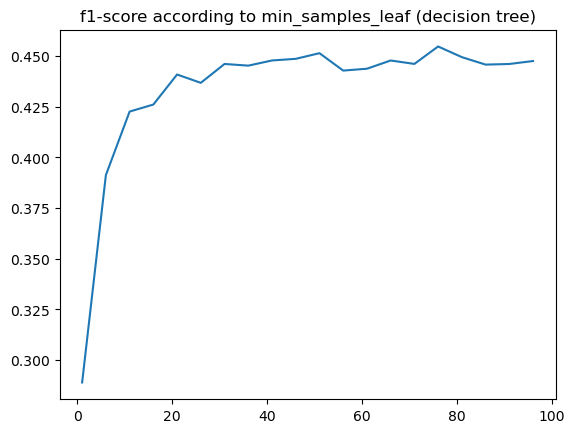

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(df_f1_score.iloc[:,0].values, df_f1_score.iloc[:,1].values)
plt.title('f1-score according to min_samples_leaf (decision tree)')

In [17]:
df_f1_score.iloc[df_f1_score["f1score"].idxmax(), 0]

76.0

In [18]:
df_f1_score2 = pd.DataFrame(columns = ["max_depth", "f1score"])
for i in range(1, 26):
    dt = DecisionTreeClassifier(class_weight = {1:df_f1_score1.iloc[df_f1_score1["f1score"].idxmax(), 0],0:1 - df_f1_score1.iloc[df_f1_score1["f1score"].idxmax(), 0]},
    min_samples_leaf=int(df_f1_score.iloc[df_f1_score["f1score"].idxmax(), 0]), max_depth=i, random_state= 42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    score = f1_score(y_pred, y_test)
    df_f1_score2.loc[len(df_f1_score2)] = [i, score]
df_f1_score2

,max_depth,f1score
0,1.0,0.000000
1,2.0,0.000000
2,3.0,0.283777
3,4.0,0.283777
4,5.0,0.321464
5,6.0,0.359058
6,7.0,0.381303
7,8.0,0.414085
8,9.0,0.427001
9,10.0,0.429765


Text(0.5, 1.0, 'f1-score according to max_depth (decision tree)')

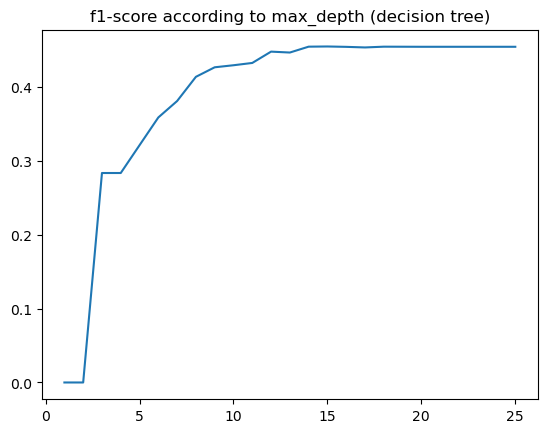

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(df_f1_score2.iloc[:,0].values, df_f1_score2.iloc[:,1].values)
plt.title('f1-score according to max_depth (decision tree)')

In [20]:
df_f1_score3 = pd.DataFrame(columns = ["max_features", "f1score"])
max_feat = [5, 10, 15, 20, 0.3, 0.5, 0.7, 0.9, "auto", "sqrt", "log2", None]
for i in range(len(max_feat)):
    dt = DecisionTreeClassifier(class_weight = {1:df_f1_score1.iloc[df_f1_score1["f1score"].idxmax(), 0],0:1 - df_f1_score1.iloc[df_f1_score1["f1score"].idxmax(), 0]},
    min_samples_leaf=int(df_f1_score.iloc[df_f1_score["f1score"].idxmax(), 0]),
    max_depth=int(df_f1_score2.iloc[df_f1_score2["f1score"].idxmax(), 0]), 
    max_features=max_feat[i], random_state= 42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    score = f1_score(y_pred, y_test)
    df_f1_score3.loc[len(df_f1_score3)] = [max_feat[i], score]
df_f1_score3

/opt/mamba/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


,max_features,f1score
0,5.0,0.387383
1,10.0,0.429167
2,15.0,0.437337
3,20.0,0.456034
4,0.3,0.423650
5,0.5,0.429167
6,0.7,0.444037
7,0.9,0.441550
8,auto,0.407030
9,sqrt,0.407030


### DT Model with optimal parameters

18
Classification metrics: 
               precision    recall  f1-score   support

           0       0.93      1.00      0.97     50000
           1       0.93      0.30      0.45      5000

    accuracy                           0.93     55000
   macro avg       0.93      0.65      0.71     55000
weighted avg       0.93      0.93      0.92     55000



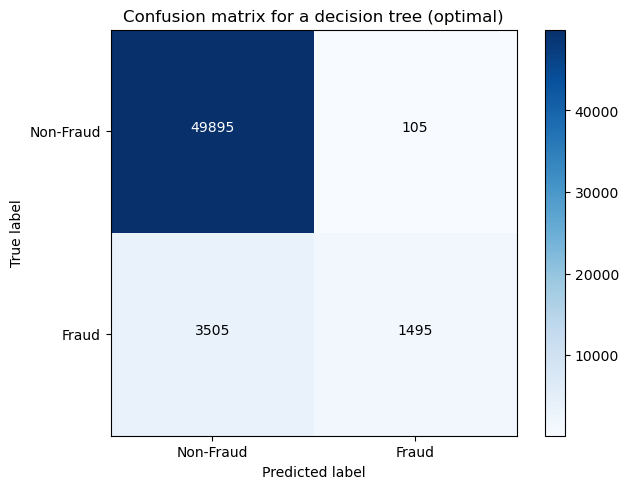

In [18]:
# Build and train model without any hyperparameters
decision_tree_opt = DecisionTreeClassifier(class_weight={1:0.91,0:0.09}, 
min_samples_leaf = 76, max_depth = 18, random_state=42)
decision_tree_opt.fit(X_train, y_train)
print(decision_tree_opt.tree_.max_depth)
# Apply model to validation data
y_pred_dt_opt = decision_tree_opt.predict(X_val)

print('Classification metrics: \n', classification_report(y_val, y_pred_dt_opt))

cnf_matrix_optdtree = confusion_matrix(y_val, y_pred_dt_opt)
plt.figure()
plot_confusion_matrix(cnf_matrix_optdtree, title='Confusion matrix for a decision tree (optimal)')
plt.show()

In [19]:
our_score(y_val, y_pred_dt_opt)

-74500

### RF Model with DT optimal parameters

Classification metrics: 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     50000
           1       0.98      0.14      0.25      5000

    accuracy                           0.92     55000
   macro avg       0.95      0.57      0.60     55000
weighted avg       0.93      0.92      0.89     55000



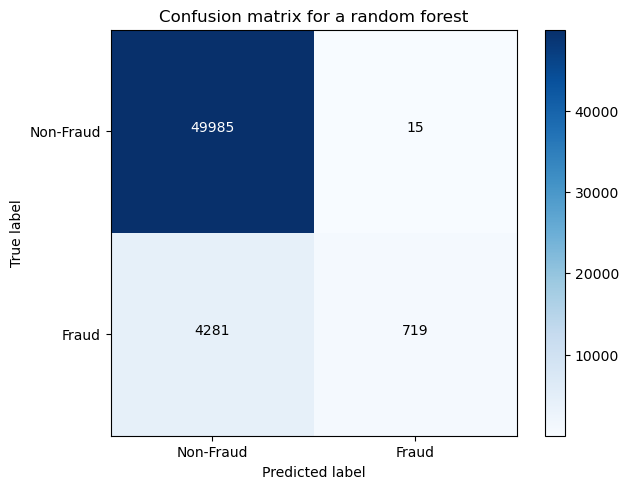

In [66]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight={1:0.86,0:0.14}, 
min_samples_leaf = 76, max_depth = 18, 
n_jobs = -1, n_estimators = 10, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

# Evaluate model
print('Classification metrics: \n', classification_report(y_val, y_pred_rf))
cnf_matrix_rf = confusion_matrix(y_val, y_pred_rf)
plt.figure()
plot_confusion_matrix(cnf_matrix_rf, title='Confusion matrix for a random forest')
plt.show()

### Hyperparameters tuning

Classification metrics: 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95     50000
           1       0.99      0.04      0.08      5000

    accuracy                           0.91     55000
   macro avg       0.95      0.52      0.51     55000
weighted avg       0.92      0.91      0.87     55000



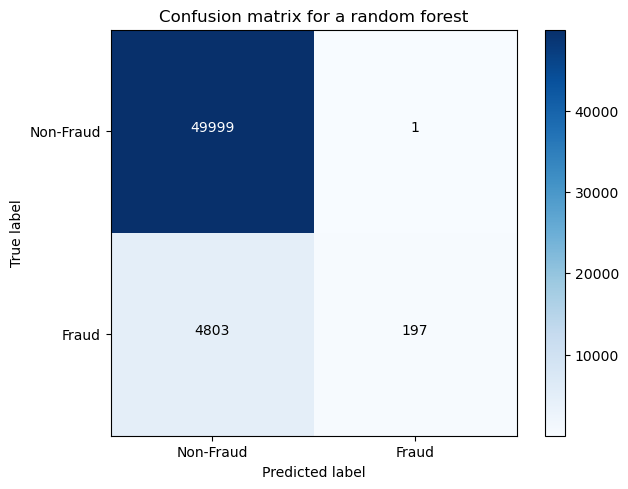

In [20]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight="balanced_subsample", n_estimators = 50,
n_jobs = -1, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

# Evaluate model
print('Classification metrics: \n', classification_report(y_val, y_pred_rf))
cnf_matrix_rf = confusion_matrix(y_val, y_pred_rf)
plt.figure()
plot_confusion_matrix(cnf_matrix_rf, title='Confusion matrix for a random forest')
plt.show()

Text(0.5, 1.0, 'f1-score according to min_samples_leaf (rf)')

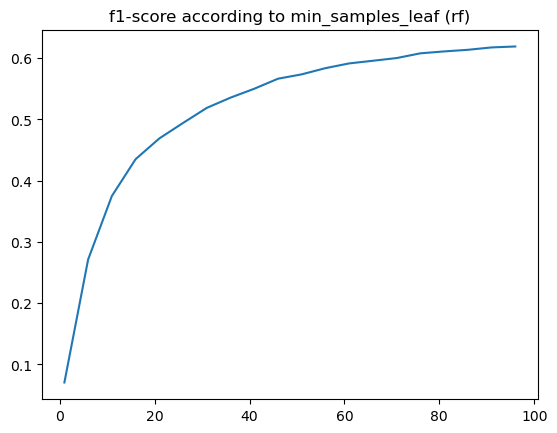

In [21]:
df_f1_score = pd.DataFrame(columns = ["min_samples_leaf", "f1score"])
for i in range(1, 100, 5):
    rf = RandomForestClassifier(class_weight = "balanced_subsample", 
    min_samples_leaf=i, n_jobs = -1, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    score = f1_score(y_pred, y_val)
    df_f1_score.loc[len(df_f1_score)] = [i, score]
df_f1_score    

import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(df_f1_score.iloc[:,0].values, df_f1_score.iloc[:,1].values)
plt.title('f1-score according to min_samples_leaf (rf)')

In [22]:
df_f1_score

,min_samples_leaf,f1score
0,1.0,0.070602
1,6.0,0.271333
2,11.0,0.374939
3,16.0,0.435092
4,21.0,0.468953
5,26.0,0.494229
6,31.0,0.518841
7,36.0,0.535541
8,41.0,0.550084
9,46.0,0.566440


In [28]:
for i in range(100, 500, 50):
    rf = RandomForestClassifier(class_weight = "balanced_subsample", 
    min_samples_leaf=i, n_jobs = -1, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    score = f1_score(y_pred, y_val)
    df_f1_score.loc[len(df_f1_score)] = [i, score]
df_f1_score    




KeyboardInterrupt



Text(0.5, 1.0, 'f1-score according to min_samples_leaf (rf)')

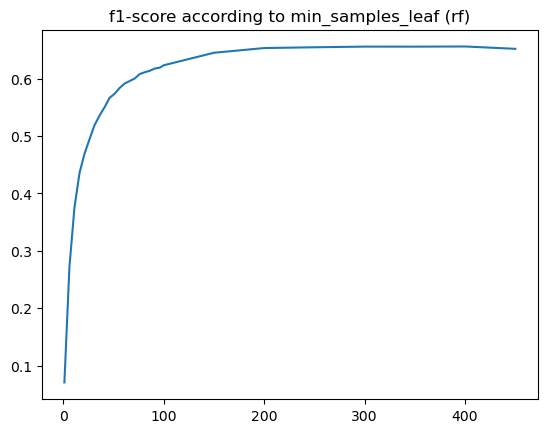

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(df_f1_score.iloc[:,0].values, df_f1_score.iloc[:,1].values)
plt.title('f1-score according to min_samples_leaf (rf)')

In [30]:
df_f1_score

,min_samples_leaf,f1score
0,1.0,0.070602
1,6.0,0.271333
2,11.0,0.374939
3,16.0,0.435092
4,21.0,0.468953
5,26.0,0.494229
6,31.0,0.518841
7,36.0,0.535541
8,41.0,0.550084
9,46.0,0.566440


Text(0.5, 1.0, 'f1-score according to max_depth (rf)')

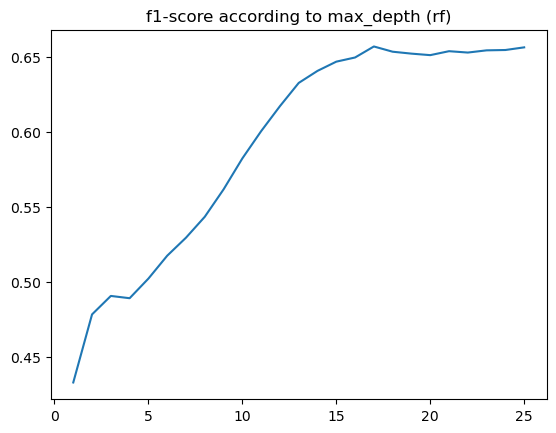

In [24]:
df_f1_score2 = pd.DataFrame(columns = ["max_depth", "f1score"])
for i in range(1, 26):
    rf = RandomForestClassifier(class_weight = "balanced_subsample",
    min_samples_leaf=int(df_f1_score.iloc[df_f1_score["f1score"].idxmax(), 0]), 
    max_depth = i, random_state= 42, n_jobs = -1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    score = f1_score(y_pred, y_val)
    df_f1_score2.loc[len(df_f1_score2)] = [i, score]
df_f1_score2

import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(df_f1_score2.iloc[:,0].values, df_f1_score2.iloc[:,1].values)
plt.title('f1-score according to max_depth (rf)')

In [25]:
df_f1_score2

,max_depth,f1score
0,1.0,0.432673
1,2.0,0.478124
2,3.0,0.490443
3,4.0,0.488923
4,5.0,0.502029
5,6.0,0.517300
6,7.0,0.529337
7,8.0,0.543296
8,9.0,0.561579
9,10.0,0.582258


Text(0.5, 1.0, 'f1-score according to max_depth (rf)')

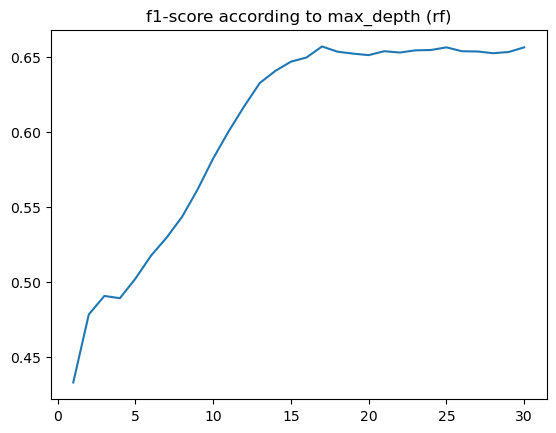

In [33]:
for i in range(25, 31):
    rf = RandomForestClassifier(class_weight = "balanced_subsample",
    min_samples_leaf=int(df_f1_score.iloc[df_f1_score["f1score"].idxmax(), 0]), 
    max_depth = i, random_state= 42, n_jobs = -1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    score = f1_score(y_pred, y_val)
    df_f1_score2.loc[len(df_f1_score2)] = [i, score]
df_f1_score2

import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(df_f1_score2.iloc[:,0].values, df_f1_score2.iloc[:,1].values)
plt.title('f1-score according to max_depth (rf)')

Text(0.5, 1.0, 'f1-score according to n_estimators (rf)')

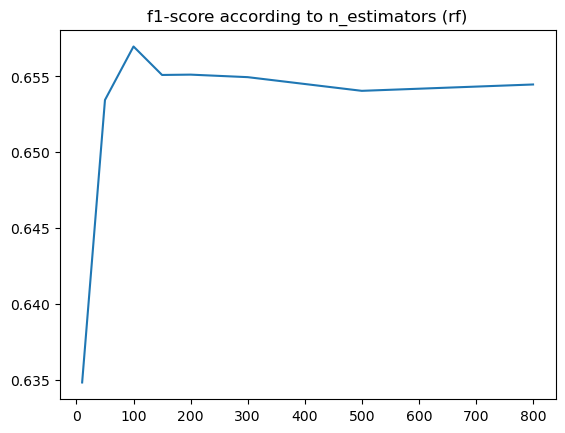

In [26]:
df_f1_score3 = pd.DataFrame(columns = ["n_estimators", "f1score"])
estimators = [10, 50, 100, 150, 200, 300, 500, 800]
for i in range(len(estimators)):
    rf = RandomForestClassifier(class_weight = "balanced_subsample",
    min_samples_leaf=int(df_f1_score.iloc[df_f1_score["f1score"].idxmax(), 0]),
    max_depth=int(df_f1_score2.iloc[df_f1_score2["f1score"].idxmax(), 0]), 
    n_estimators = estimators[i],
    n_jobs = -1, random_state= 42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    score = f1_score(y_pred, y_val)
    df_f1_score3.loc[len(df_f1_score3)] = [estimators[i], score]
df_f1_score3

import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(df_f1_score3.iloc[:,0].values, df_f1_score3.iloc[:,1].values)
plt.title('f1-score according to n_estimators (rf)')

In [27]:
df_f1_score3

,n_estimators,f1score
0,10.0,0.634834
1,50.0,0.653445
2,100.0,0.656969
3,150.0,0.655093
4,200.0,0.655115
5,300.0,0.654949
6,500.0,0.654047
7,800.0,0.654466


### RF with optimal parameters

In [53]:
from sklearn.ensemble import RandomForestClassifier
rf_opt = RandomForestClassifier(class_weight="balanced_subsample",  
min_samples_leaf = 400, max_depth = 17, n_estimators = 100,
n_jobs = -1,  random_state = 42)
rf_opt.fit(X_train, y_train)
y_pred_rf_opt = rf_opt.predict(X_val)



Classification metrics: 
               precision    recall  f1-score   support

           0       0.96      0.97      0.97     50000
           1       0.69      0.62      0.65      5000

    accuracy                           0.94     55000
   macro avg       0.82      0.80      0.81     55000
weighted avg       0.94      0.94      0.94     55000



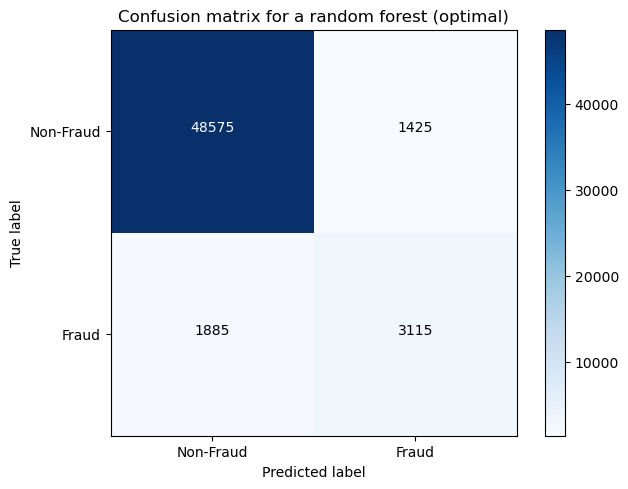

In [54]:
# Evaluate model
print('Classification metrics: \n', classification_report(y_val, y_pred_rf_opt))
cnf_matrix_rf_opt = confusion_matrix(y_val, y_pred_rf_opt)
plt.figure()
plot_confusion_matrix(cnf_matrix_rf_opt, title='Confusion matrix for a random forest (optimal)')
plt.show()

In [45]:
our_score(y_val, y_pred_rf_opt)

-2046805

### XGBoost

Classification metrics: 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     50000
           1       1.00      0.12      0.22      5000

    accuracy                           0.92     55000
   macro avg       0.96      0.56      0.59     55000
weighted avg       0.93      0.92      0.89     55000



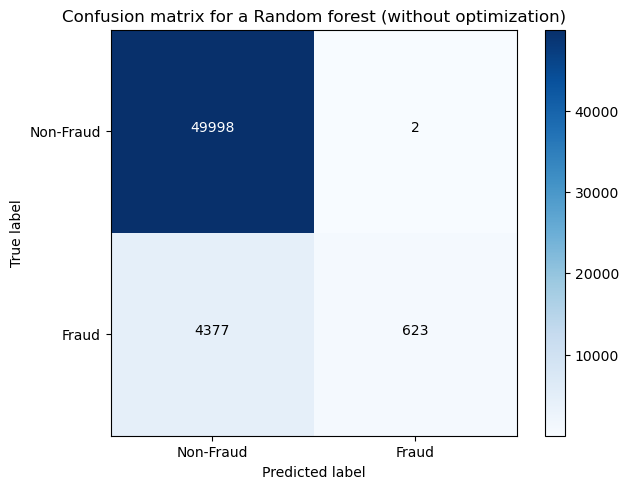

In [39]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_train, y_train, verbose=True)

y_pred_xgb = xgb.predict(X_val)

# Evaluate model
print('Classification metrics: \n', classification_report(y_val, y_pred_xgb))
cnf_matrix_xgb = confusion_matrix(y_val, y_pred_xgb)
plt.figure()
plot_confusion_matrix(cnf_matrix_xgb, title='Confusion matrix for a Random forest (without optimization)')
plt.show()

Classification metrics: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.97     50000
           1       0.83      0.54      0.66      5000

    accuracy                           0.95     55000
   macro avg       0.89      0.77      0.81     55000
weighted avg       0.94      0.95      0.94     55000



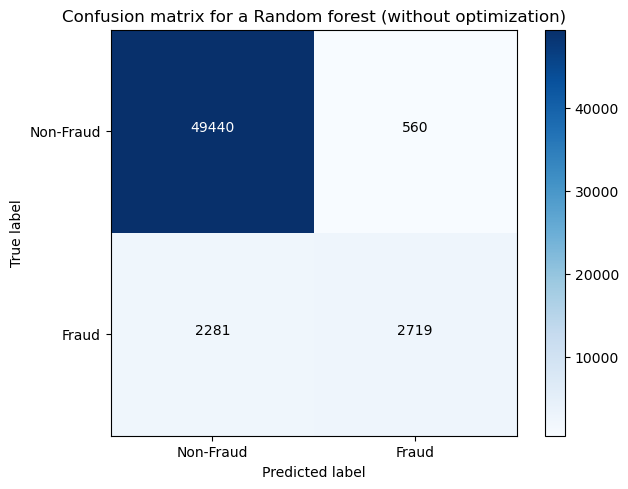

In [55]:
from xgboost import XGBClassifier
xgb = XGBClassifier(scale_pos_weight=100, random_state = 42)
xgb.fit(X_train, y_train, verbose=True)

y_pred_xgb = xgb.predict(X_val)

# Evaluate model
print('Classification metrics: \n', classification_report(y_val, y_pred_xgb))
cnf_matrix_xgb = confusion_matrix(y_val, y_pred_xgb)
plt.figure()
plot_confusion_matrix(cnf_matrix_xgb, title='Confusion matrix for XGBOOST (without optimization)')
plt.show()